In [37]:
import nltk as nl
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity, treebank, stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import numpy as np
import pandas as pd
import scipy
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

np.set_printoptions(threshold=sys.maxsize)

stop = set()

flag =1
inFile = open("./stoplist.txt","r")
while flag == 1:
    line = inFile.readline()
    if line == "":
        flag = 0
    stop.add(line[:-1])
inFile.close()
#GET THE TRAINING DATA PRE-PROCESSED
#big = pd.read_csv('big_train.csv') #NOT WORKING YET
medium = pd.read_csv('medium_train.csv') 
tiny = pd.read_csv('tiny_train.csv')

def clean_data(df):
    comments =[]
    tags={}
    vocablist={}
    for i in range(len(df)):
        tag = df.iloc[i, 2] or df.iloc[i, 3] or df.iloc[i, 4] or df.iloc[i, 5] or df.iloc[i, 6] or df.iloc[i, 7]
        tokens = nl.regexp_tokenize(df.iloc[i, 1], r'[,\.\?\n\t0123456789 •/\'><;\|:·[\]{}+-=_()!@#$%^&*~`"]\s*', gaps=True)
        tokens = [token.lower() for token in tokens]
        reduced = set()
        for word in tokens:
            if word not in stop:
                reduced.add(word)
                if word not in vocablist.keys():
                    vocablist[word] = 1
                else:
                    vocablist[word]+=1
        un_token = TreebankWordDetokenizer() 
        comments.append(un_token.detokenize(reduced))
        tags[i] = tag
    return comments, tags

comments, tags = clean_data(medium)
count_vector = CountVectorizer()
dataframe = count_vector.fit_transform(comments)
bag_o_words = dataframe.toarray()#pd.DataFrame(dataframe.toarray(), columns = count_vector.get_feature_names_out())
features = count_vector.get_feature_names_out()

#Begin creating Naive Bayes
X = bag_o_words
tags = pd.DataFrame(list(tags.values()))
Y = tags[0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(x_train,y_train)
prediction = nb.predict(x_test)
nb_medium_accuracy = accuracy_score(y_test, prediction)

lr = LogisticRegression()
lr.fit(x_train, y_train)
predict = lr.predict(x_test)
lr__medium_accuracy = accuracy_score(y_test, predict)

#NOW DO THE SAME FOR TINY
comments, tags = clean_data(tiny)
count_vector = CountVectorizer()
dataframe = count_vector.fit_transform(comments)
# pd.DataFrame(dataframe.toarray(), columns = count_vector.get_feature_names_out())
bag_o_words = dataframe.toarray()
features = count_vector.get_feature_names_out()

#Begin creating Naive Bayes
X = bag_o_words
tags = pd.DataFrame(list(tags.values()))
Y = tags[0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(x_train, y_train)
prediction = nb.predict(x_test)
nb_tiny_accuracy = accuracy_score(y_test, prediction)

lr = LogisticRegression()
lr.fit(x_train, y_train)
predict = lr.predict(x_test)
lr_tiny_accuracy = accuracy_score(y_test, predict)


Text(0, 0.5, 'Accuracy')

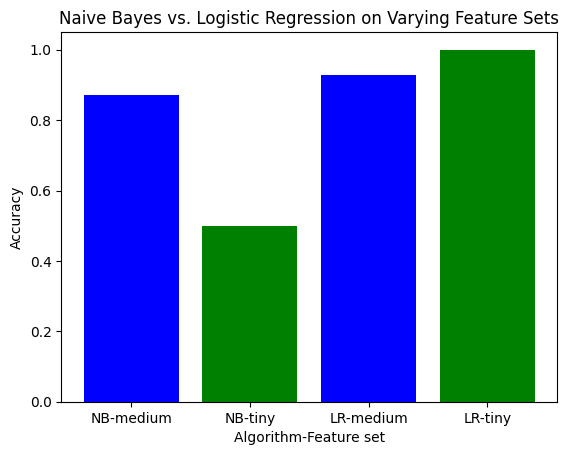

In [41]:
algorithm = ['NB-medium', 'NB-tiny', 'LR-medium', 'LR-tiny']
accuracy = [nb_medium_accuracy, nb_tiny_accuracy, lr__medium_accuracy, lr_tiny_accuracy]
colors = ['blue', 'green']
plt.bar(algorithm, accuracy, color=colors)
plt.title("Naive Bayes vs. Logistic Regression on Varying Feature Sets")
plt.xlabel("Algorithm-Feature set")
plt.ylabel("Accuracy")


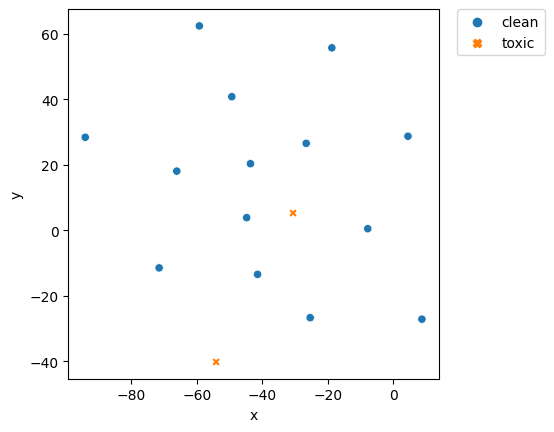

In [36]:
#TSNE STUFF
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(x_train)

y_train = y_train.replace(1, "toxic")
y_train = y_train.replace(0, "clean")
tsne_result_df = pd.DataFrame(
    {'x': tsne_result[:, 0], 'y': tsne_result[:, 1], 'label': y_train})
fig, ax = plt.subplots(1)
sns.scatterplot(x='x', y='y', hue='label', style='label',
                data=tsne_result_df, ax=ax)
lim = (-10, 10)
ax.set_xlim(auto=1)
ax.set_ylim(auto=1)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [ ]:
    # reduced = set()
    # for word in tokens:
    #     if word not in stop:
    #         reduced.add(word)
    bag = bag_o_words.to_numpy()
    # bag_matrix = np.empty(0)
# for i, row in bag_o_words.iterrows():
#     val = df.loc[i, :].values.flatten().tolist()
#     bag_matrix=np.append(bag_matrix,val, axis=0)

# bag_matrix

# count_vector = CountVectorizer()
# dataframe = count_vector.fit_transform(comments)
# bag_o_words = dataframe.toarray()
# words = count_vector.get_feature_names_out()


#GET THE TEST DATA PRE-PROCESSED
# d = pd.read_csv('test_data.csv', delimiter=',')

# test_tags={}
# comments2 =[]
# count=1
# for i in range(len(d)):
#     count+=1
#     tag = d.iloc[i, 2] or d.iloc[i, 3] or d.iloc[i, 4] or d.iloc[i, 5] or d.iloc[i, 6] or d.iloc[i, 7]
#     tokens = nl.regexp_tokenize(d.iloc[i, 1], r'[,\.\?\n\t0123456789 •/\'\|><;:[\]{}+-·=_()!@#$%^&*~`"]\s*', gaps=True)
#     tokens = [token.lower() for token in tokens]
#     less=set()
#     for token in tokens:
#         if token in vocablist.keys():
#             less.add(token)
#             un_token = TreebankWordDetokenizer() 
#     comments2.append(un_token.detokenize(less))
#     test_tags[i] = tag
# test_tags[count]=0 
# comments2.append(un_token.detokenize(list(vocablist.keys())))

# count_vector2 = CountVectorizer()
# dataframe2 = count_vector2.fit_transform(comments2)
# bag_test = dataframe2.toarray()
# features2 = count_vector2.get_feature_names_out()

# test_tags = pd.DataFrame(list(test_tags.values()))
# custom_testX = bag_test
# custom_testY = test_tags[0]